Best Alpha: 0.001
Ridge Regression - MSE: 416343820107.2891, R-squared: 0.9952845967500664


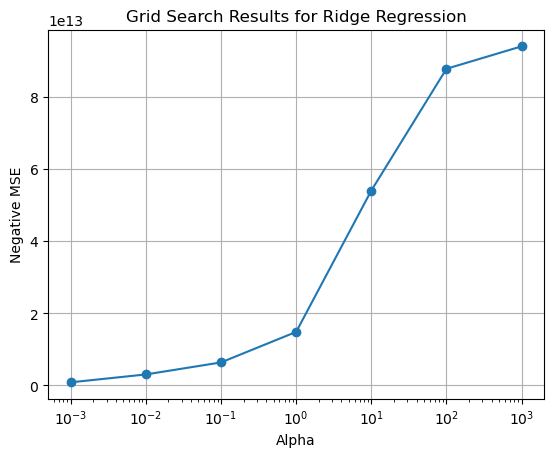

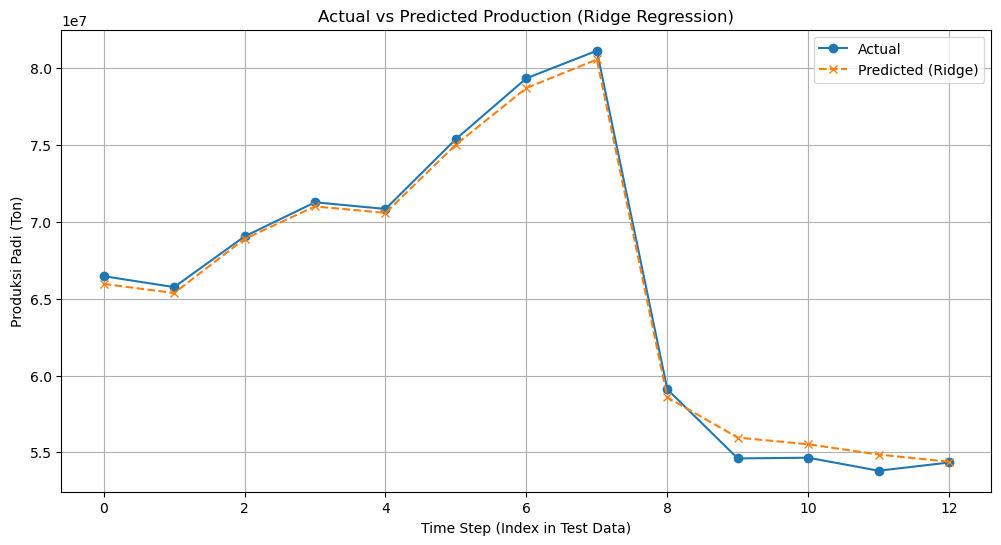

C:\Users\HP\AppData\Local\Temp\ipykernel_17264\2535442430.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_row['Produksi_delta'] = latest_row['Produksi_lag1'] - latest_row['Produksi_lag2']
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


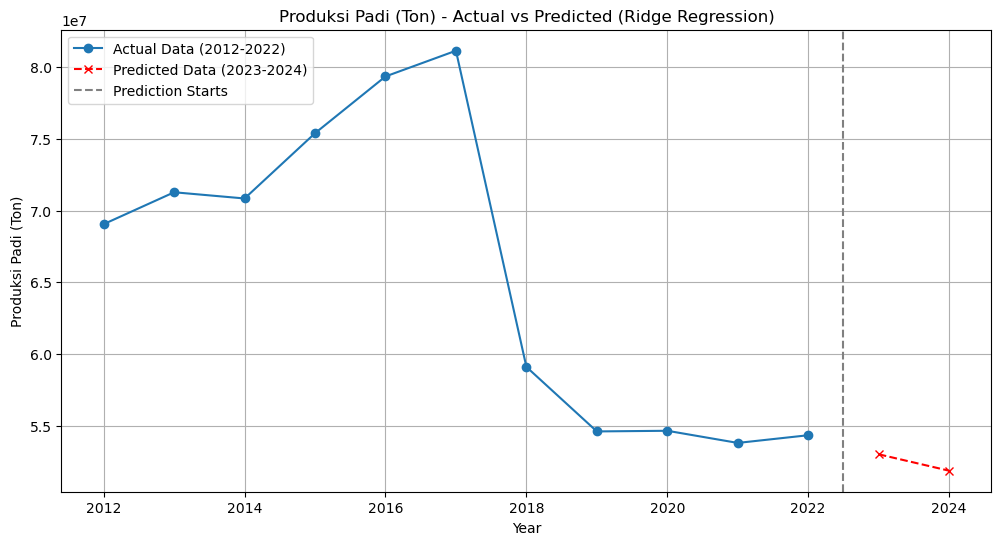

Prediksi Produksi Padi tahun 2023: 53,009,791.18 Ton
Prediksi Produksi Padi tahun 2024: 51,863,937.07 Ton
           Feature   Coefficient
0    Produksi_lag1  4.753681e+07
11  Produksi_delta  2.651719e+07
3    Produksi_lag4  2.838222e+06
1    Produksi_lag2  2.323342e+06
8    Produksi_lag9  1.434098e+06
4    Produksi_lag5  1.983569e+05
9   Produksi_lag10  3.292635e+04
10  Produksi_lag11  5.772728e+03
6    Produksi_lag7 -3.758185e+05
7    Produksi_lag8 -6.147102e+05
2    Produksi_lag3 -7.627322e+05
5    Produksi_lag6 -1.280764e+06


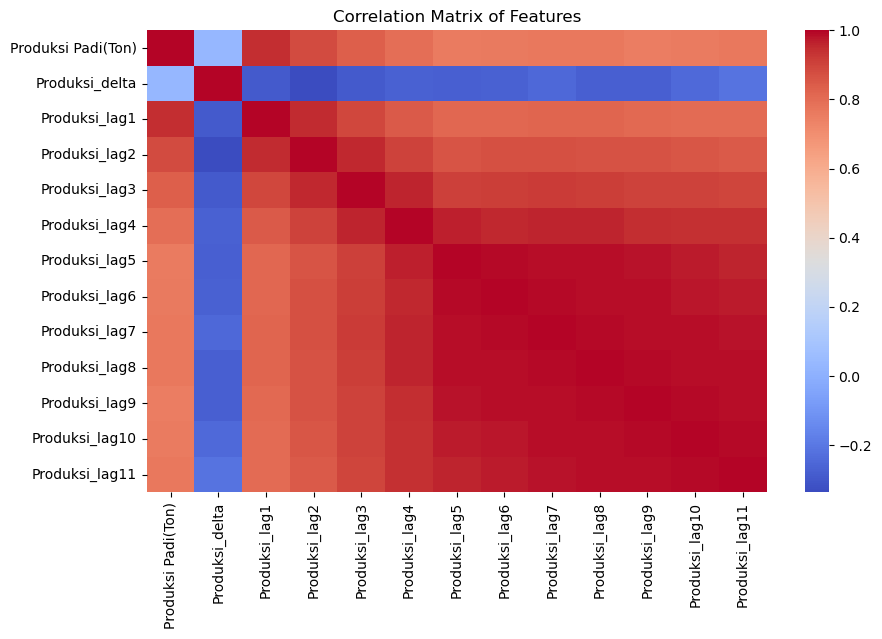

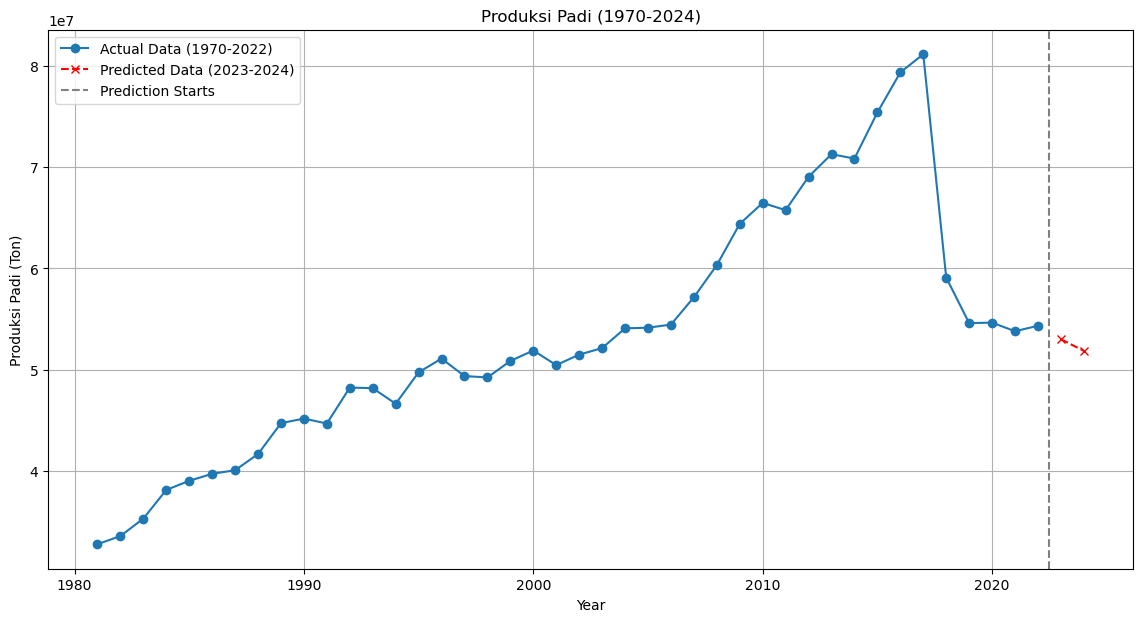

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV

file_path = r"C:\Users\HP\Documents\data mining\dataset\produksiPadi.xlsx"
data = pd.read_excel(file_path)

data.head()

# Drop 'Tahun' dari dataset
data = data.drop(columns=['Tahun'])

# Tambahkan fitur perubahan tahunan
data['Produksi_delta'] = data['Produksi Padi(Ton)'].diff()

# lagging features
num_lags = 11
for i in range(1, num_lags + 1):
    data[f'Produksi_lag{i}'] = data['Produksi Padi(Ton)'].shift(i)

# drop missing values setelah pembuatan lagging
data_lagged = data.dropna().reset_index(drop=True)

# Feature target target split
X = data_lagged[[f'Produksi_lag{i}' for i in range(1, num_lags + 1)] + ['Produksi_delta']]
y = data_lagged['Produksi Padi(Ton)']

# Normalisasi data menggunakan Min-Max Scaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Membagi dataset menjadi data latih (70%) dan data uji (30%)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42, shuffle=False)

# Inisialisasi model regresi linear
model = LinearRegression()

# Melatih model pada data latih
model.fit(X_train, y_train)

ridge = Ridge()
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error',  cv=TimeSeriesSplit(n_splits=5))
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_ridge = best_model.predict(X_test)
best_alpha = grid_search.best_params_['alpha']
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Best Alpha: {best_alpha}")
print(f"Ridge Regression - MSE: {mse_ridge}, R-squared: {r2_ridge}")

# Plot hasil GridSearch
results = pd.DataFrame(grid_search.cv_results_)
plt.plot(results['param_alpha'], -results['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Negative MSE')
plt.title('Grid Search Results for Ridge Regression')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", marker='o', linestyle='-')
plt.plot(y_pred_ridge, label="Predicted (Ridge)", marker='x', linestyle='--')
plt.title("Actual vs Predicted Production (Ridge Regression)")
plt.xlabel("Time Step (Index in Test Data)")
plt.ylabel("Produksi Padi (Ton)")
plt.legend()
plt.grid(True)
plt.show()



# Asumsikan data produksi hingga 2022 sudah tersedia
latest_data = data_lagged.copy()

# Buat lagging features untuk prediksi
for i in range(1, num_lags + 1):
    latest_data[f'Produksi_lag{i}'] = latest_data['Produksi Padi(Ton)'].shift(i)

# Ambil data terbaru (tahun 2022)
latest_row = latest_data.iloc[-1]

# Pastikan semua fitur yang digunakan saat pelatihan (termasuk Produksi_delta) diikutsertakan
# Tambahkan Produksi_delta pada prediksi 2023
latest_row['Produksi_delta'] = latest_row['Produksi_lag1'] - latest_row['Produksi_lag2']

# Prediksi untuk tahun 2023 menggunakan semua fitur
X_2023 = latest_row[[f'Produksi_lag{i}' for i in range(1, num_lags + 1)] + ['Produksi_delta']].values.reshape(1, -1)
X_2023 = scaler.transform(X_2023)  # Normalisasi menggunakan scaler yang sama
pred_2023 = best_model.predict(X_2023)  # Gunakan model Ridge Regression

# Update lagging untuk prediksi tahun 2024
new_row = latest_row.copy()
new_row['Produksi_lag1'] = pred_2023[0]  # Prediksi 2023 menjadi lag1
for i in range(2, num_lags + 1):
    new_row[f'Produksi_lag{i}'] = latest_row[f'Produksi_lag{i-1}']

# Tambahkan Produksi_delta untuk prediksi tahun 2024
new_row['Produksi_delta'] = new_row['Produksi_lag1'] - new_row['Produksi_lag2']

# Prediksi untuk tahun 2024
X_2024 = new_row[[f'Produksi_lag{i}' for i in range(1, num_lags + 1)] + ['Produksi_delta']].values.reshape(1, -1)
X_2024 = scaler.transform(X_2024)  # Normalisasi
pred_2024 = best_model.predict(X_2024)

# Data untuk visualisasi
years = list(range(2012, 2023))  # Misal data aktual dari 2012 hingga 2022
actual_data = data_lagged['Produksi Padi(Ton)'].values[-len(years):]
predicted_years = [2023, 2024]
predicted_data = [pred_2023[0], pred_2024[0]]

# Gabungkan data aktual dan prediksi
years_combined = years + predicted_years
data_combined = list(actual_data) + predicted_data

# Plot visualisasi
plt.figure(figsize=(12, 6))
plt.plot(years, actual_data, label="Actual Data (2012-2022)", marker='o', linestyle='-')
plt.plot(predicted_years, predicted_data, label="Predicted Data (2023-2024)", marker='x', linestyle='--', color='red')
plt.axvline(x=2022.5, color='gray', linestyle='--', label="Prediction Starts")
plt.title("Produksi Padi (Ton) - Actual vs Predicted (Ridge Regression)")
plt.xlabel("Year")
plt.ylabel("Produksi Padi (Ton)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Prediksi Produksi Padi tahun 2023: {pred_2023[0]:,.2f} Ton")
print(f"Prediksi Produksi Padi tahun 2024: {pred_2024[0]:,.2f} Ton")

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

plt.figure(figsize=(10, 6))
sns.heatmap(data_lagged.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Matrix of Features")
plt.show()


# Asumsikan data dari 1970 hingga 2022 dalam variabel `historical_data`
historical_years = list(range(1970, 2023))
historical_produksi = [None] * len(historical_years)  # Placeholder jika tidak ada data
# Isi data dari 1970-2022 (sesuaikan dengan data Anda)
historical_produksi[-len(data_lagged['Produksi Padi(Ton)']):] = data_lagged['Produksi Padi(Ton)'].values

# Tambahkan prediksi untuk 2023 dan 2024
all_years = historical_years + [2023, 2024]
all_produksi = historical_produksi + [pred_2023[0], pred_2024[0]]

plt.figure(figsize=(14, 7))
plt.plot(historical_years, historical_produksi, label="Actual Data (1970-2022)", marker='o', linestyle='-')
plt.plot([2023, 2024], [pred_2023[0], pred_2024[0]], label="Predicted Data (2023-2024)", marker='x', linestyle='--', color='red')
plt.axvline(x=2022.5, color='gray', linestyle='--', label="Prediction Starts")
plt.title("Produksi Padi (1970-2024)")
plt.xlabel("Year")
plt.ylabel("Produksi Padi (Ton)")
plt.legend()
plt.grid(True)
plt.show()

